# Multi-variate Rregression Metamodel with DOE based on random sampling
* Input variable space should be constructed using random sampling, not classical factorial DOE
* Linear fit is often inadequate but higher-order polynomial fits often leads to overfitting i.e. learns spurious, flawed relationships between input and output
* R-square fit can often be misleding measure in case of high-dimensional regression
* Metamodel can be constructed by selectively discovering features (or their combination) which matter and shrinking other high-order terms towards zero

#### LASSO: Least Absolute Shrinkage and Selection Operator
$$ {\displaystyle \min _{\beta _{0},\beta }\left\{{\frac {1}{N}}\sum _{i=1}^{N}(y_{i}-\beta _{0}-x_{i}^{T}\beta )^{2}\right\}{\text{ subject to }}\sum _{j=1}^{p}|\beta _{j}|\leq t.} $$

### Import libraries

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Generate random (equivalent to Latin Hypercube sampling done in Optislang) feature vectors

In [78]:
X=np.array(10*np.random.randn(37,5))

In [79]:
df=pd.DataFrame(X,columns=['Feature'+str(l) for l in range(1,6)])

In [80]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5
0,-15.453597,-17.805068,24.016184,-10.495994,-5.722487
1,-21.221785,-11.447068,3.759493,0.348747,-12.695441
2,13.695024,7.178703,19.250129,-9.773332,-0.195619
3,19.766801,11.073039,1.034897,9.889190,0.091331
4,-5.338243,13.330948,-4.877764,0.574421,8.255401


### Plot the random distributions of input features

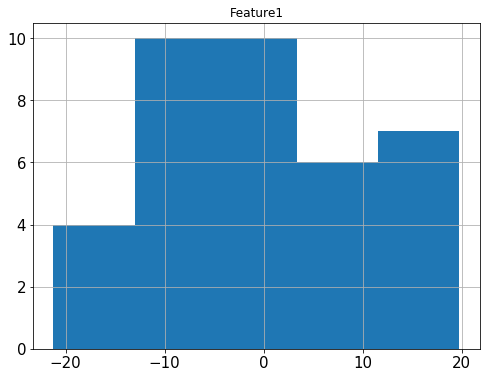

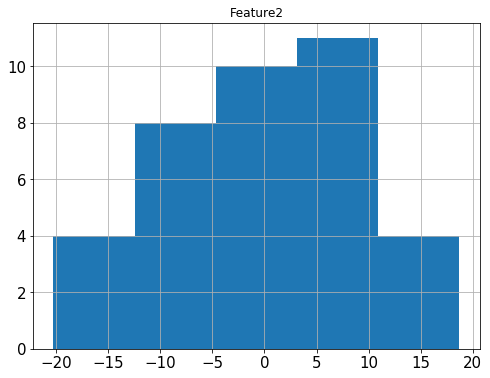

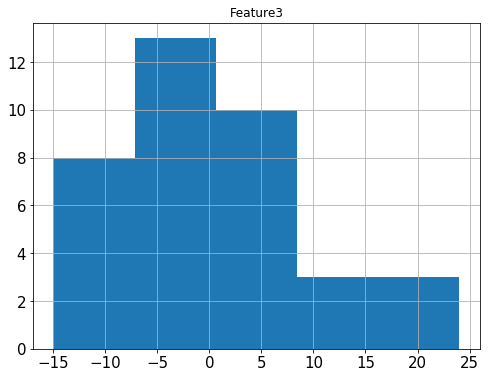

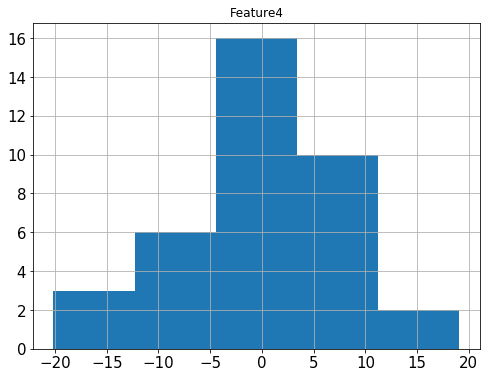

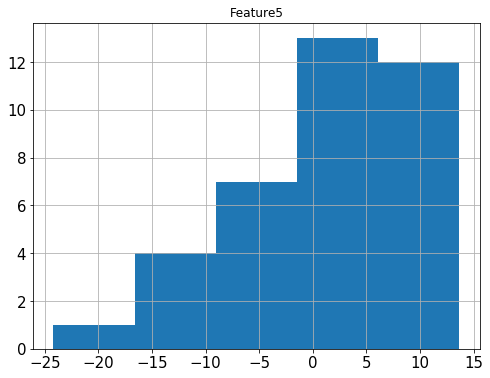

In [81]:
for i in df.columns:
    df.hist(i,bins=5,xlabelsize=15,ylabelsize=15,figsize=(8,6))

### Generate the output variable by analytic function + Gaussian noise (our goal will be to *'learn'* this function)

#### Let's construst the ground  truth  or  originating  function  as  follows: 
 
$$ y=f(x_1,x_2,x_3,x_4,x_5)= 5x_1^2+13x_2+0.1x_1x_3^2+2x_4x_5+0.1x_5^3+0.8x_1x_4x_5+\psi(x)\ :\ \psi(x) = {\displaystyle f(x\;|\;\mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}\;e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}}$$

In [82]:
df['y']=5*df['Feature1']**2+13*df['Feature2']+0.1*df['Feature3']**2*df['Feature1'] \
+2*df['Feature4']*df['Feature5']+0.1*df['Feature5']**3+0.8*df['Feature1']*df['Feature4']*df['Feature5'] \
+30*np.random.normal(loc=5,scale=2)

In [83]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,y
0,-15.453597,-17.805068,24.016184,-10.495994,-5.722487,-431.953540
1,-21.221785,-11.447068,3.759493,0.348747,-12.695441,2072.648112
2,13.695024,7.178703,19.250129,-9.773332,-0.195619,1701.292666
3,19.766801,11.073039,1.034897,9.889190,0.091331,2253.726636
4,-5.338243,13.330948,-4.877764,0.574421,8.255401,486.519017


### Plot single-variable scatterplots

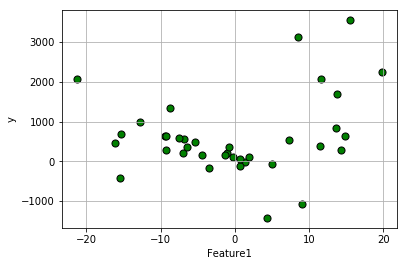

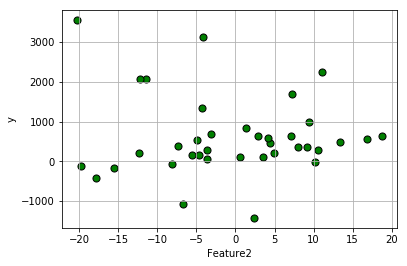

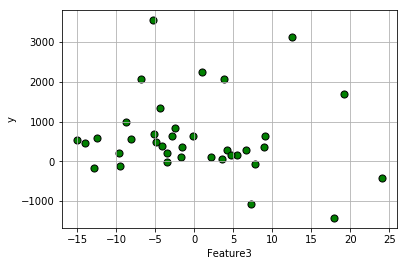

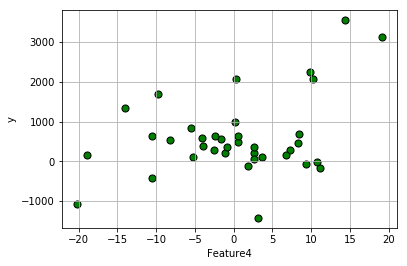

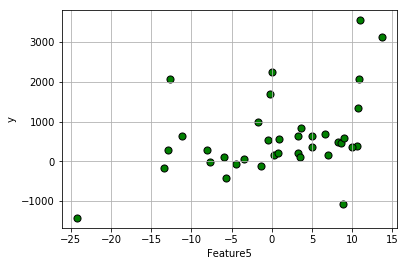

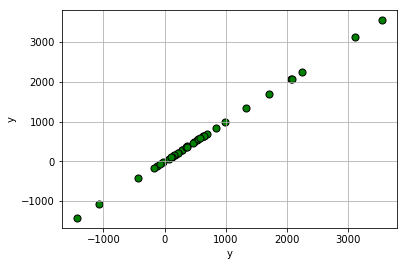

In [84]:
for i in df.columns:
    df.plot.scatter(i,'y', edgecolors=(0,0,0),s=50,c='g',grid=True)

### Standard linear regression

In [85]:
from sklearn.linear_model import LinearRegression

In [86]:
linear_model = LinearRegression(normalize=True)

In [87]:
X_linear=df.drop('y',axis=1)
y_linear=df['y']

In [88]:
linear_model.fit(X_linear,y_linear)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [89]:
y_pred_linear = linear_model.predict(X_linear)

### R-square of simple linear fit is very bad, coefficients have no meaning i.e. we did not 'learn' the function

In [90]:
RMSE_linear = np.sqrt(np.sum(np.square(y_pred_linear-y_linear)))

In [91]:
print("Root-mean-square error of linear model:",RMSE_linear)

Root-mean-square error of linear model: 4838.87696595


In [92]:
coeff_linear = pd.DataFrame(linear_model.coef_,index=df.drop('y',axis=1).columns, columns=['Linear model coefficients'])
coeff_linear

,Linear model coefficients
Feature1,9.172156
Feature2,-0.945568
Feature3,10.948377
Feature4,45.069370
Feature5,52.445902


In [93]:
print ("R2 value of linear model:",linear_model.score(X_linear,y_linear))

R2 value of linear model: 0.347548929728


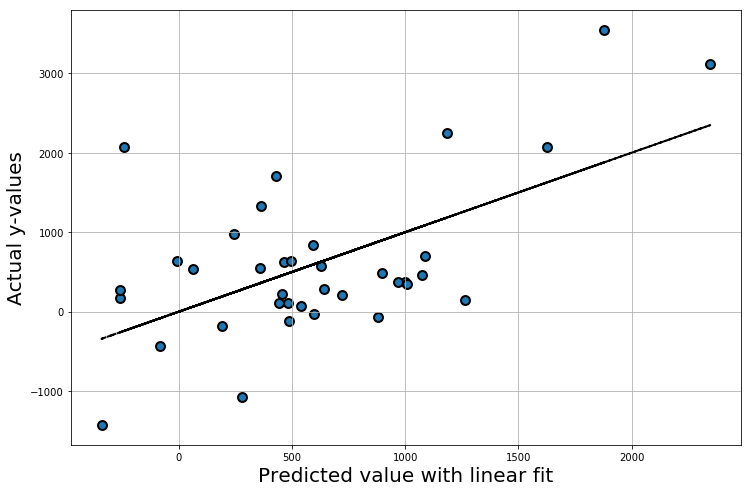

In [94]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with linear fit",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred_linear,y_linear,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred_linear,y_pred_linear, 'k--', lw=2)

### Create polynomial features

In [95]:
from sklearn.preprocessing import PolynomialFeatures

In [96]:
poly = PolynomialFeatures(3,include_bias=False)

In [97]:
X_poly = poly.fit_transform(X)
X_poly_feature_name = poly.get_feature_names(['Feature'+str(l) for l in range(1,6)])
print(X_poly_feature_name)
print(len(X_poly_feature_name))

['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature1^2', 'Feature1 Feature2', 'Feature1 Feature3', 'Feature1 Feature4', 'Feature1 Feature5', 'Feature2^2', 'Feature2 Feature3', 'Feature2 Feature4', 'Feature2 Feature5', 'Feature3^2', 'Feature3 Feature4', 'Feature3 Feature5', 'Feature4^2', 'Feature4 Feature5', 'Feature5^2', 'Feature1^3', 'Feature1^2 Feature2', 'Feature1^2 Feature3', 'Feature1^2 Feature4', 'Feature1^2 Feature5', 'Feature1 Feature2^2', 'Feature1 Feature2 Feature3', 'Feature1 Feature2 Feature4', 'Feature1 Feature2 Feature5', 'Feature1 Feature3^2', 'Feature1 Feature3 Feature4', 'Feature1 Feature3 Feature5', 'Feature1 Feature4^2', 'Feature1 Feature4 Feature5', 'Feature1 Feature5^2', 'Feature2^3', 'Feature2^2 Feature3', 'Feature2^2 Feature4', 'Feature2^2 Feature5', 'Feature2 Feature3^2', 'Feature2 Feature3 Feature4', 'Feature2 Feature3 Feature5', 'Feature2 Feature4^2', 'Feature2 Feature4 Feature5', 'Feature2 Feature5^2', 'Feature3^3', 'Feature3^2 Feature4', 'F

In [98]:
df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
df_poly.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature1 Feature4,Feature1 Feature5,...,Feature3^3,Feature3^2 Feature4,Feature3^2 Feature5,Feature3 Feature4^2,Feature3 Feature4 Feature5,Feature3 Feature5^2,Feature4^3,Feature4^2 Feature5,Feature4 Feature5^2,Feature5^3
0,-15.453597,-17.805068,24.016184,-10.495994,-5.722487,238.813659,275.152347,-371.136432,162.200862,88.433008,...,13851.985264,-6053.849078,-3300.599522,2645.764341,1442.488639,786.454576,-1156.300538,-630.422885,-343.710827,-187.393471
1,-21.221785,-11.447068,3.759493,0.348747,-12.695441,450.364147,242.927223,-79.783161,-7.401034,269.419924,...,53.135896,4.929117,-179.434718,0.457246,-16.645146,605.933472,0.042416,-1.544076,56.209028,-2046.178007
2,13.695024,7.178703,19.250129,-9.773332,-0.195619,187.553677,98.312514,263.630971,-133.846016,-2.679000,...,7133.471192,-3621.678794,-72.489856,1838.734178,36.803257,0.736637,-933.529330,-18.685094,-0.373992,-0.007486
3,19.766801,11.073039,1.034897,9.889190,0.091331,390.726434,218.878557,20.456610,195.477657,1.805316,...,1.108388,10.591446,0.097816,101.208905,0.934705,0.008632,967.124046,8.931784,0.082489,0.000762
4,-5.338243,13.330948,-4.877764,0.574421,8.255401,28.496841,-71.163840,26.038690,-3.066398,-44.069336,...,-116.054593,13.666955,196.417286,-1.609464,-23.130719,-332.427601,0.189536,2.723946,39.147722,562.619066


In [99]:
df_poly['y']=df['y']
df_poly.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature1 Feature4,Feature1 Feature5,...,Feature3^2 Feature4,Feature3^2 Feature5,Feature3 Feature4^2,Feature3 Feature4 Feature5,Feature3 Feature5^2,Feature4^3,Feature4^2 Feature5,Feature4 Feature5^2,Feature5^3,y
0,-15.453597,-17.805068,24.016184,-10.495994,-5.722487,238.813659,275.152347,-371.136432,162.200862,88.433008,...,-6053.849078,-3300.599522,2645.764341,1442.488639,786.454576,-1156.300538,-630.422885,-343.710827,-187.393471,-431.953540
1,-21.221785,-11.447068,3.759493,0.348747,-12.695441,450.364147,242.927223,-79.783161,-7.401034,269.419924,...,4.929117,-179.434718,0.457246,-16.645146,605.933472,0.042416,-1.544076,56.209028,-2046.178007,2072.648112
2,13.695024,7.178703,19.250129,-9.773332,-0.195619,187.553677,98.312514,263.630971,-133.846016,-2.679000,...,-3621.678794,-72.489856,1838.734178,36.803257,0.736637,-933.529330,-18.685094,-0.373992,-0.007486,1701.292666
3,19.766801,11.073039,1.034897,9.889190,0.091331,390.726434,218.878557,20.456610,195.477657,1.805316,...,10.591446,0.097816,101.208905,0.934705,0.008632,967.124046,8.931784,0.082489,0.000762,2253.726636
4,-5.338243,13.330948,-4.877764,0.574421,8.255401,28.496841,-71.163840,26.038690,-3.066398,-44.069336,...,13.666955,196.417286,-1.609464,-23.130719,-332.427601,0.189536,2.723946,39.147722,562.619066,486.519017


In [100]:
X_train=df_poly.drop('y',axis=1)
y_train=df_poly['y']

### Polynomial model without regularization and cross-validation

In [101]:
poly = LinearRegression(normalize=True)

In [102]:
model_poly=poly.fit(X_train,y_train)
y_poly = poly.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
print("Root-mean-square error of simple polynomial model:",RMSE_poly)

Root-mean-square error of simple polynomial model: 1.89910302223e-11


In [103]:
coeff_poly = pd.DataFrame(model_poly.coef_,index=df_poly.drop('y',axis=1).columns, 
                          columns=['Coefficients polynomial model'])
coeff_poly

,Coefficients polynomial model
Feature1,1.393774
Feature2,11.469286
Feature3,-7.258182
Feature4,4.967388
Feature5,0.428594
Feature1^2,4.610796
Feature1 Feature2,0.130565
Feature1 Feature3,0.168512
Feature1 Feature4,1.652596
Feature1 Feature5,0.850184


#### R-square value of the simple polynomial model is perfect but the model is flawed as shown above i.e. it learned wrong coefficients and overfitted the to the data

In [104]:
print ("R2 value of simple polynomial model:",model_poly.score(X_train,y_train))

R2 value of simple polynomial model: 1.0


### Metamodel (Optislang style :) - polynomial model with cross-validation and LASSO regularization
** This is an advanced machine learning method which prevents over-fitting by penalizing high-valued coefficients i.e. keep them bounded **

In [130]:
from sklearn.linear_model import LassoCV

In [131]:
model1 = LassoCV(cv=10,verbose=0,normalize=True,eps=0.001,n_alphas=100, tol=0.0001,max_iter=5000)

In [132]:
model1.fit(X_train,y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=5000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=0)

In [133]:
y_pred1 = np.array(model1.predict(X_train))

In [134]:
RMSE_1=np.sqrt(np.sum(np.square(y_pred1-y_train)))
print("Root-mean-square error of Metamodel:",RMSE_1)

Root-mean-square error of Metamodel: 10.6254345131


In [135]:
coeff1 = pd.DataFrame(model1.coef_,index=df_poly.drop('y',axis=1).columns, columns=['Coefficients Metamodel'])
coeff1

,Coefficients Metamodel
Feature1,0.000000
Feature2,12.891291
Feature3,0.000000
Feature4,0.000000
Feature5,0.000000
Feature1^2,4.991474
Feature1 Feature2,-0.000000
Feature1 Feature3,0.000000
Feature1 Feature4,0.000000
Feature1 Feature5,0.000000


In [136]:
model1.score(X_train,y_train)

0.99999685404731742

In [140]:
model1.alpha_

0.11791796322572394

#### Recall that the ground  truth  or  originating  function  is  as  follows: 
 
$$ y=f(x_1,x_2,x_3,x_4,x_5)= 5x_1^2+13x_2+0.1x_1x_3^2+2x_4x_5+0.1x_5^3+0.8x_1x_4x_5+\psi(x) $$

### Printing only the non-zero coefficients of the *metamodel*

In [137]:
coeff1[coeff1['Coefficients Metamodel']!=0]

,Coefficients Metamodel
Feature2,12.891291
Feature1^2,4.991474
Feature4 Feature5,1.995183
Feature1 Feature3^2,0.099441
Feature1 Feature4^2,0.000024
Feature1 Feature4 Feature5,0.799360
Feature3^2 Feature5,0.001067
Feature5^3,0.099169


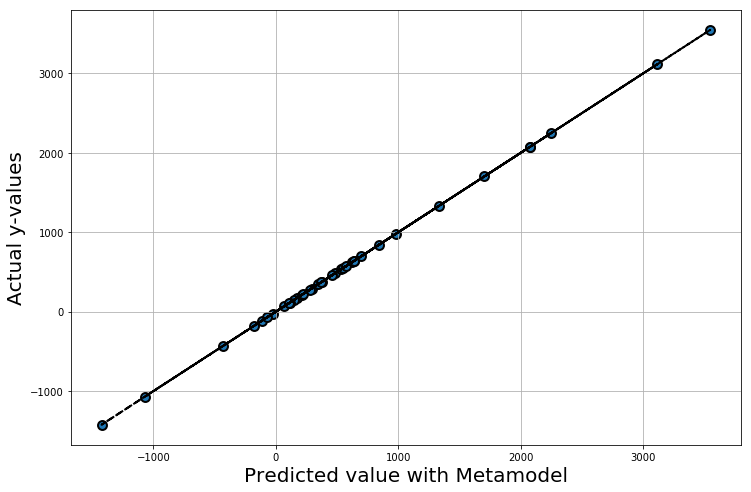

In [138]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with Metamodel",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred1,y_train,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred1,y_pred1, 'k--', lw=2)

(-2.2215799690947899,
 1.0784200309052099,
 -117815.4824067771,
 2474147.0440959162)

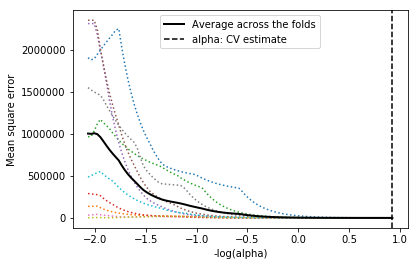

In [139]:
# Display results
m_log_alphas = -np.log10(model1.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model1.mse_path_, ':')
plt.plot(m_log_alphas, model1.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model1.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.axis('tight')